# Degree Rips bifiltrations

**Note.** I'm not satisfied with this interface, so it may be subject to change.

In [1]:
import numpy as np
import gudhi as gd
from multipers.plots import plot_signed_measures, plot_surfaces
import multipers as mp
from multipers.function_rips import get_degree_rips,function_rips_surface, function_rips_signed_measure
import matplotlib.pyplot as plt
from multipers.data import three_annulus, noisy_annulus

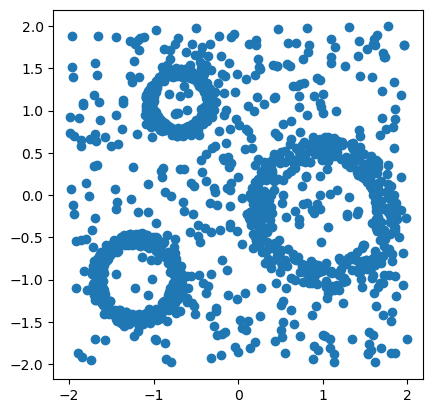

In [16]:
X = three_annulus(1000,500)
degrees = np.linspace(0,500,100, dtype=int)
st = gd.RipsComplex(points=X, max_edge_length=1.2).create_simplex_tree()
st_multi, max_degree = get_degree_rips(st,degrees=degrees, grid_strategy="regular_closest", resolution=200)
plt.scatter(*X.T)
plt.gca().set_aspect(1)

Text(396.2790404040403, 0.5, 'degree')

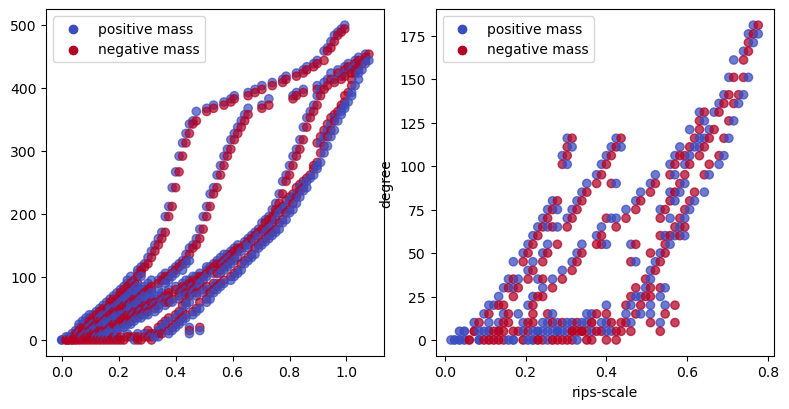

In [17]:
sms = function_rips_signed_measure(st_multi, homological_degrees= [0,1], mobius_inversion=True, zero_pad=False)
plot_signed_measures(sms)

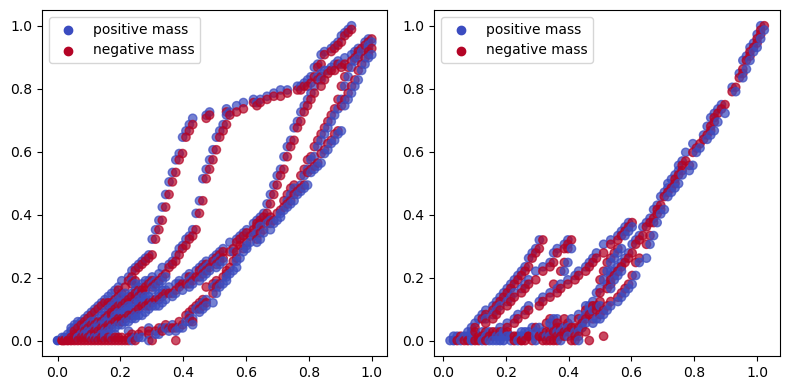

In [12]:
from multipers.ml.signed_measures import SignedMeasureFormatter
sms_, = SignedMeasureFormatter(normalize=True).fit_transform([sms])
plot_signed_measures(sms_)

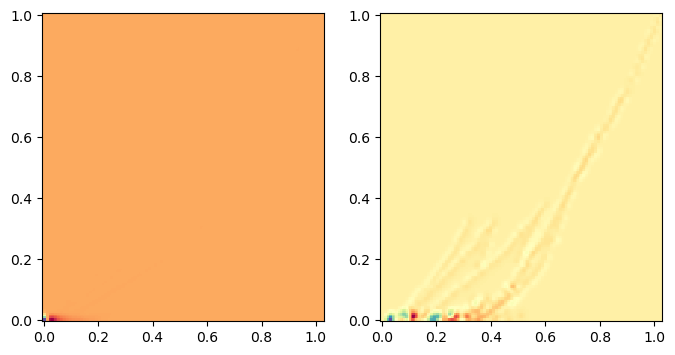

In [13]:
from multipers.ml.signed_measures import SignedMeasure2Convolution
imgs = SignedMeasure2Convolution(bandwidth=.01, plot=True, grid_strategy="regular_closest", resolution=500, kernel="gaussian").fit_transform([sms_])

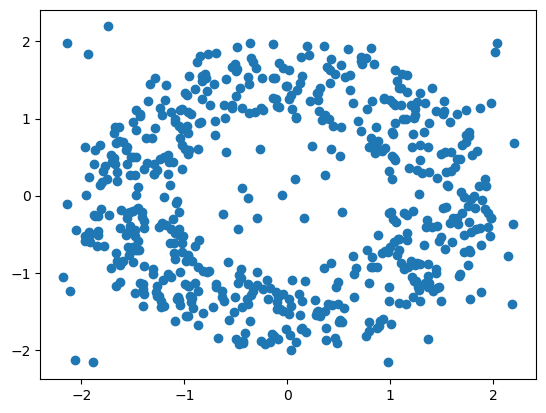

In [14]:
X = noisy_annulus(500,100)
degrees = np.linspace(1,100,100, dtype=int)
st = gd.RipsComplex(points=X, max_edge_length=1).create_simplex_tree()
st_multi, max_degree = get_degree_rips(st,degrees=degrees, grid_strategy="regular_closest", resolution=1000)
plt.scatter(*X.T)

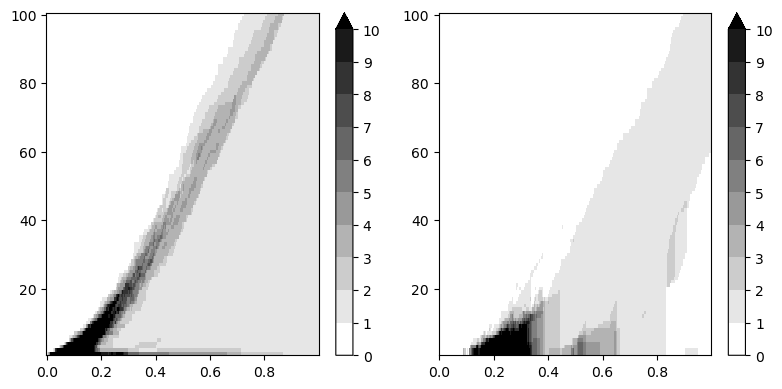

In [15]:
surfaces = function_rips_surface(st_multi, homological_degrees= [0,1], mobius_inversion=False, zero_pad=False)
plot_surfaces(surfaces, discrete_surface=True)